In [6]:
# CELL 0: imports & display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["axes.grid"] = True


In [25]:
data_m = pd.read_csv("../../../data/processed/us_macro_monthly.csv", index_col=0, parse_dates=True)
factors = pd.read_csv("../../../data/processed/yield_curve_factors.csv", index_col=0, parse_dates=True)

# merge and keep monthly index
df = pd.concat([data_m, factors], axis=1).sort_index()
df = df.asfreq("ME")

# OOS probability series
oos = pd.read_csv("../../../data/processed/recession_prob_12m_oos_multivar.csv",
                  index_col=0, parse_dates=True).rename(columns={"phat":"p_recession","y":"y"})
oos = oos.asfreq("ME")

df = pd.merge(df, oos, how='inner', left_index=True, right_index=True)

# download prices and compute monthly returns
start_date = oos.index[0]
tickers = ["SPY", "VFITX"]
px = yf.download(tickers, start=start_date, auto_adjust=True, progress=False)["Close"]
px = px.resample("ME").last()

ret = px.pct_change().dropna()
ret.rename(columns={'SPY': 'ret_eq', 'VFITX': 'ret_bond'}, inplace=True)

df = pd.merge(df, ret, how='inner', left_index=True, right_index=True)

In [27]:
import pandas_datareader.data as web

tbill = web.DataReader("TB3MS", "fred", start=start_date)
tbill.rename(columns={"TB3MS": "TB3MS_rate"}, inplace=True)
tbill = tbill.resample("ME").last()

df['ret_cash'] = tbill["TB3MS_rate"] / 100 / 12
df

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,...,log_m2,USREC,PC1_Level,PC2_Slope,PC3_Curvature,p_recession,y,ret_eq,ret_bond,ret_cash
1997-02-28,5.185714,5.898421,6.419474,159.700,3846.3,12115.472,5.2,0.521053,3.032258,5.038506,...,8.254867,0.0,2.842413,0.298536,-0.107357,0.134124,0,0.009566,0.000984,0.004175
1997-03-31,5.386129,6.222000,6.694500,159.800,3861.2,12115.472,5.2,0.472500,2.765273,4.727549,...,8.258733,0.0,3.438947,0.213070,-0.213227,0.077201,0,-0.044123,-0.013035,0.004283
1997-04-30,5.507333,6.448182,6.885455,159.900,3877.0,12317.221,5.1,0.437273,2.434337,4.848960,...,8.262817,0.0,3.809586,0.107432,-0.331155,0.051048,0,0.062604,0.016124,0.004300
1997-05-31,5.504194,6.276667,6.710952,159.900,3889.2,12317.221,4.9,0.434286,2.237852,4.841492,...,8.265959,0.0,3.449868,0.158003,-0.302337,0.066194,0,0.063207,0.008343,0.004208
1997-06-30,5.555667,6.094762,6.493810,160.200,3906.0,12317.221,5.0,0.399048,2.233567,4.929483,...,8.270269,0.0,3.055571,0.213164,-0.282599,0.068870,0,0.041103,0.010030,0.004108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,1.205000,2.998095,3.143333,295.072,21642.9,21967.045,3.6,0.145238,8.999298,5.714872,...,9.982433,0.0,-4.369261,0.474048,-1.103851,0.996404,0,-0.082460,-0.008270,0.001242
2022-07-31,1.675806,3.036000,2.896000,294.940,21641.7,22125.625,3.5,-0.140000,8.447778,4.913177,...,9.982377,0.0,-4.290733,1.197957,-0.680093,0.996713,0,0.092087,0.019216,0.001858
2022-08-31,2.330000,3.250000,2.897826,295.162,21606.9,22125.625,3.6,-0.352174,8.216255,3.824420,...,9.980768,0.0,-3.959897,1.525008,-0.569224,0.996134,0,-0.040802,-0.029086,0.002192
2022-09-30,2.555000,3.856667,3.519048,296.421,21521.1,22125.625,3.5,-0.337619,8.205752,2.583035,...,9.976789,0.0,-2.688142,1.495161,-0.660584,0.995388,0,-0.092446,-0.032554,0.002608


In [28]:
# CELL 1: config — tell the notebook which columns to use
COL_P = "p_recession"                     # recession probability
COL_SLOPE = "spread_10y_2y"               # or "PC2_Slope"
COL_EQ = "ret_eq"
COL_BD = "ret_bond"
COL_CASH = "ret_cash"

# Macro risk thresholds for hysteresis
TH_LOW = 0.5
TH_HIGH = 0.6

In [29]:
# CELL 2: helpers — stats & safe ops
def ann_stats(r: pd.Series, periods_per_year=12):
    r = r.dropna()
    if r.empty:
        return dict(n=0, ann_return=np.nan, ann_vol=np.nan, sharpe=np.nan,
                    sortino=np.nan, max_dd=np.nan, hit_rate=np.nan)
    cum = (1 + r).cumprod()
    ann_ret = cum.iloc[-1]**(periods_per_year / len(r)) - 1
    ann_vol = r.std() * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    downside = r[r < 0]
    dd_vol = downside.std() * np.sqrt(periods_per_year) if len(downside) > 1 else np.nan
    sortino = ann_ret / dd_vol if dd_vol and dd_vol > 0 else np.nan
    roll_max = cum.cummax()
    dd = (cum / roll_max - 1.0).min()
    hit = (r > 0).mean()
    return dict(n=len(r), ann_return=ann_ret, ann_vol=ann_vol, sharpe=sharpe,
                sortino=sortino, max_dd=float(dd), hit_rate=hit)

def summarize_by_group(ret: pd.Series, grp: pd.Series, name="ret"):
    out = []
    for g, r in ret.groupby(grp):
        s = ann_stats(r)
        s.update(regime=int(g), metric=name)
        out.append(s)
    return pd.DataFrame(out).set_index(["metric","regime"]).sort_index()


In [30]:
# CELL 3: macro risk state with hysteresis and curve state
def macro_state_with_hysteresis(p: pd.Series, th_low=0.4, th_high=0.7):
    """
    Returns a binary state series:
      0 = expansion/low-risk, 1 = recession/high-risk,
    with hysteresis (needs to cross th_high to go 0->1, and below th_low to go 1->0).
    """
    p = p.copy()
    state = np.zeros(len(p), dtype=int)
    cur = 0
    for i, val in enumerate(p.fillna(method="ffill")):
        if cur == 0 and val >= th_high:
            cur = 1
        elif cur == 1 and val <= th_low:
            cur = 0
        state[i] = cur
    return pd.Series(state, index=p.index, name="macro_state")



def curve_state(slope: pd.Series, zero=0.0):
    """
    0 = steep (slope >= 0), 1 = flat/inverted (slope < 0)
    """
    cs = (slope < zero).astype(int)
    cs.name = "curve_state"
    return cs


In [31]:
# CELL 4: build 4-regime label (0..3) and human-readable names
REGIME_NAMES = {
    0: "A Expansion–Steep",
    1: "B Expansion–Flat",
    2: "C Recession–Flat",
    3: "D Recession–Steep",
}

def build_regime_labels(df, col_p=COL_P, col_slope=COL_SLOPE, th_low=TH_LOW, th_high=TH_HIGH):
    ms = macro_state_with_hysteresis(df[col_p], th_low, th_high)   # 0 expansion, 1 recession
    cs = curve_state(df[col_slope])                                 # 0 steep, 1 flat/inverted
    # Map to 4 regimes: r = 2*ms + cs
    r = 2*ms + cs
    r.name = "regime"
    return r, ms, cs


In [32]:
# CELL 5: compute regimes
regime, macro_st, curve_st = build_regime_labels(df)
df09 = df.copy()
df09["macro_state"] = macro_st
df09["curve_state"] = curve_st
df09["regime"] = regime

# basic sanity
df09[["p_recession", COL_SLOPE, "macro_state", "curve_state", "regime"]].tail(3)


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_73334/172407848.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  for i, val in enumerate(p.fillna(method="ffill")):


,p_recession,spread_10y_2y,macro_state,curve_state,regime
2022-08-31,0.996134,-0.352174,1,1,3
2022-09-30,0.995388,-0.337619,1,1,3
2022-10-31,0.992694,-0.391500,1,1,3


In [33]:
# CELL 6: regime frequency & transition matrix
freq = df09["regime"].value_counts(normalize=True).reindex([0,1,2,3]).fillna(0.0)
freq.index = [REGIME_NAMES[i] for i in freq.index]
print("Regime frequency (%):")
display((freq*100).round(1))

# Transition matrix P(i->j)
reg_series = df09["regime"].dropna().astype(int)
pairs = pd.crosstab(reg_series.shift(1), reg_series, normalize="index").reindex(index=[0,1,2,3], columns=[0,1,2,3]).fillna(0.0)
pairs.index = [REGIME_NAMES[i] for i in pairs.index]
pairs.columns = [REGIME_NAMES[i] for i in pairs.columns]
print("Regime transition probabilities:")
display((pairs*100).round(1))


Regime frequency (%):


A Expansion–Steep    73.8
B Expansion–Flat      1.0
C Recession–Flat     16.8
D Recession–Steep     8.4
Name: proportion, dtype: float64

Regime transition probabilities:


,A Expansion–Steep,B Expansion–Flat,C Recession–Flat,D Recession–Steep
A Expansion–Steep,96.1,0.4,3.1,0.4
B Expansion–Flat,33.3,33.3,0.0,33.3
C Recession–Flat,13.5,0.0,78.8,7.7
D Recession–Steep,0.0,4.0,16.0,80.0


In [34]:
# CELL 7: conditional performance — equities & bonds by regime
eq_stats = summarize_by_group(df09[COL_EQ], df09["regime"], name="EQ")
bd_stats = summarize_by_group(df09[COL_BD], df09["regime"], name="BD")
cond_table = pd.concat([eq_stats, bd_stats]).round(3)
cond_table


n  ann_return  ann_vol  sharpe  sortino  max_dd  hit_rate
metric regime                                                             
EQ     0       228       0.102    0.155   0.661    0.907  -0.483     0.640
       1         3       0.488    0.028  17.585      NaN   0.000     1.000
       2        52      -0.000    0.163  -0.001   -0.001  -0.215     0.596
       3        26       0.047    0.159   0.297    0.468  -0.134     0.577
BD     0       228       0.056    0.049   1.154    2.037  -0.052     0.636
       1         3       0.103    0.007  13.945      NaN   0.000     1.000
       2        52       0.028    0.046   0.606    1.134  -0.092     0.481
       3        26       0.053    0.052   1.018    1.342  -0.068     0.692

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_73334/1603120194.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


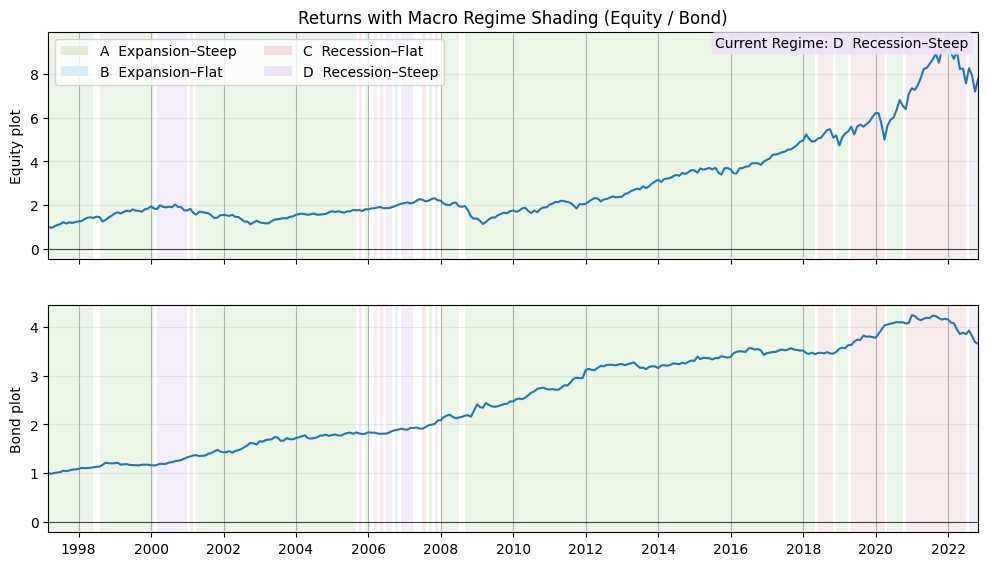

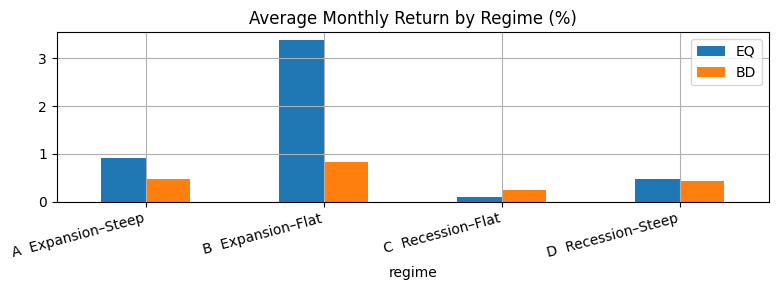

In [43]:
# CELL 8 (replacement): monthly EQ/BD returns with regime shading + current quadrant badge
import matplotlib.dates as mdates
from matplotlib.patches import Patch, FancyBboxPatch

# --- config ---
COL_EQ = "ret_eq"
COL_BD = "ret_bond"
REGIME_COL = "regime"
REGIME_NAMES = {
    0: "A  Expansion–Steep",
    1: "B  Expansion–Flat",
    2: "C  Recession–Flat",
    3: "D  Recession–Steep",
}
# background colors per regime (soft tints so bars stand out)
REGIME_COLORS = {
    0: "#dff0d8",  # light green
    1: "#d9edf7",  # light blue
    2: "#f2dede",  # light red
    3: "#ede3f7",  # light purple
}

# --- helpers: contiguous regime spans (start_idx, end_idx, regime) ---
def contiguous_spans(series: pd.Series):
    s = series.dropna().astype(int).values
    idx = series.dropna().index
    spans = []
    start = 0
    for i in range(1, len(s)):
        if s[i] != s[i-1]:
            spans.append((idx[start], idx[i-1], int(s[i-1])))
            start = i
    spans.append((idx[start], idx[len(s)-1], int(s[len(s)-1])))
    return spans

# --- build figure ---
fig, axes = plt.subplots(2, 1, figsize=(12, 6.5), sharex=True, gridspec_kw={"hspace": 0.20})

# regime shading spans
spans = contiguous_spans(df09[REGIME_COL])

# (A) Equity plot
ax = axes[0]
for s0, s1, rg in spans:
    ax.axvspan(s0, s1, color=REGIME_COLORS[rg], alpha=0.6, lw=0)

ax.plot(df09.index, (1+df09[COL_EQ]).cumprod())
ax.axhline(0, color="k", lw=0.8, alpha=0.7)
ax.set_ylabel("Equity plot")
ax.set_title("Returns with Macro Regime Shading (Equity / Bond)")

# (B) Bond monthly returns
ax2 = axes[1]
for s0, s1, rg in spans:
    ax2.axvspan(s0, s1, color=REGIME_COLORS[rg], alpha=0.6, lw=0)

ax2.plot(df09.index, (1+df09[COL_BD]).cumprod())
ax2.axhline(0, color="k", lw=0.8, alpha=0.7)
ax2.set_ylabel("Bond plot")

# x-axis formatting
axes[-1].xaxis.set_major_locator(mdates.YearLocator(base=2))  # tick every 2 years
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
for ax in axes:
    ax.grid(True, axis="y", alpha=0.25)
    ax.margins(x=0)

# regime legend (patches)
leg_patches = [Patch(facecolor=REGIME_COLORS[k], edgecolor="none", label=REGIME_NAMES[k]) for k in range(4)]
axes[0].legend(handles=leg_patches, ncol=2, loc="upper left", frameon=True)

# current quadrant badge
cur_regime = int(df09[REGIME_COL].iloc[-1])
cur_name = REGIME_NAMES[cur_regime]
badge_text = f"Current Regime: {cur_name}"
bbox = dict(boxstyle="round,pad=0.3", facecolor=REGIME_COLORS[cur_regime], edgecolor="none", alpha=0.9)
axes[0].text(0.99, 0.98, badge_text, transform=axes[0].transAxes, ha="right", va="top", fontsize=10, bbox=bbox)

plt.tight_layout()
plt.show()


# (B) conditional average monthly returns bars
avg_monthly = pd.DataFrame({
    "EQ": df09.groupby("regime")[COL_EQ].mean(),
    "BD": df09.groupby("regime")[COL_BD].mean(),
}).reindex([0,1,2,3])

(ax := avg_monthly.mul(100).plot(kind="bar", figsize=(8,3)))
ax.set_title("Average Monthly Return by Regime (%)")
ax.set_xticklabels([REGIME_NAMES[i] for i in [0,1,2,3]], rotation=15, ha="right")
plt.tight_layout()
plt.show()


Regime portfolio: {'n': 309, 'ann_return': np.float64(0.0818), 'ann_vol': np.float64(0.1094), 'sharpe': np.float64(0.7478), 'sortino': np.float64(0.9867), 'max_dd': -0.3897, 'hit_rate': np.float64(0.644)}
60/40 benchmark: {'n': 309, 'ann_return': np.float64(0.0741), 'ann_vol': np.float64(0.0926), 'sharpe': np.float64(0.7996), 'sortino': np.float64(1.1035), 'max_dd': -0.2967, 'hit_rate': np.float64(0.6505)}


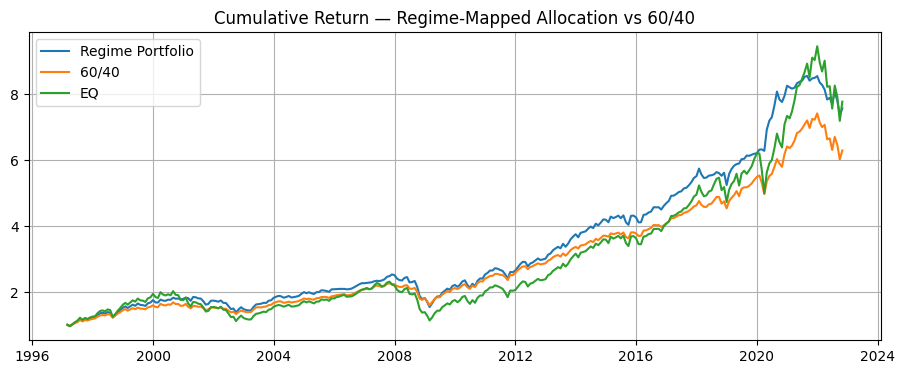

In [39]:
# CELL 9: optional mini-backtest — fixed weights per regime (edit to taste)
# A: 80/20, B: 60/40, C: 20/80, D: 40/60
W = {
    0: {"eq":0.80, "bd":0.20},
    1: {"eq":0.60, "bd":0.40},
    2: {"eq":0.20, "bd":0.80},
    3: {"eq":0.40, "bd":0.60},
}

w_eq = df09["regime"].map({k:v["eq"] for k,v in W.items()}).fillna(0.0)
w_bd = df09["regime"].map({k:v["bd"] for k,v in W.items()}).fillna(0.0)

ret_port = w_eq*df09[COL_EQ] + w_bd*df09[COL_BD]
stats_port = ann_stats(ret_port)
stats_6040 = ann_stats(0.6*df09[COL_EQ] + 0.4*df09[COL_BD])

print("Regime portfolio:", {k: round(v,4) if isinstance(v,float) else v for k,v in stats_port.items()})
print("60/40 benchmark:", {k: round(v,4) if isinstance(v,float) else v for k,v in stats_6040.items()})

# plot cumulative
cum_port = (1 + ret_port).cumprod()
cum_6040 = (1 + 0.6*df09[COL_EQ] + 0.4*df09[COL_BD]).cumprod()
cum_eq = (1 + df[COL_EQ]).cumprod()

plt.figure(figsize=(11,4))
plt.plot(cum_port.index, cum_port, label="Regime Portfolio")
plt.plot(cum_6040.index, cum_6040, label="60/40")
plt.plot(cum_eq, label="EQ")
plt.title("Cumulative Return — Regime-Mapped Allocation vs 60/40")
plt.legend(); plt.show()


In [37]:
# CELL 10: concise executive summary table for the report
summary = pd.DataFrame({
    "Regime": [REGIME_NAMES[i] for i in [0,1,2,3]],
    "Freq_%": (df09["regime"].value_counts(normalize=True).reindex([0,1,2,3]).fillna(0.0)*100).values,
    "EQ_avg_m%": (df09.groupby("regime")[COL_EQ].mean().reindex([0,1,2,3]).fillna(0.0)*100).values,
    "BD_avg_m%": (df09.groupby("regime")[COL_BD].mean().reindex([0,1,2,3]).fillna(0.0)*100).values,
    "EQ_hit": (df09.groupby("regime")[COL_EQ].apply(lambda x: (x>0).mean()).reindex([0,1,2,3]).fillna(0.0)).values,
    "BD_hit": (df09.groupby("regime")[COL_BD].apply(lambda x: (x>0).mean()).reindex([0,1,2,3]).fillna(0.0)).values,
}).round(2)

summary


,Regime,Freq_%,EQ_avg_m%,BD_avg_m%,EQ_hit,BD_hit
0,A Expansion–Steep,73.79,0.92,0.47,0.64,0.64
1,B Expansion–Flat,0.97,3.37,0.82,1.00,1.00
2,C Recession–Flat,16.83,0.11,0.24,0.60,0.48
3,D Recession–Steep,8.41,0.49,0.44,0.58,0.69


## Collapse 4 regimes into 3

In [45]:
# COLLAPSE A+B → Expansion (3-regime: 0=Expansion, 1=Recession-Flat, 2=Recession-Steep)

REGIME4_NAMES = {0:"A Expansion–Steep", 1:"B Expansion–Flat", 2:"C Recession–Flat", 3:"D Recession–Steep"}
REGIME3_NAMES = {0:"Expansion", 1:"Recession–Flat", 2:"Recession–Steep"}

# df09 must already have `regime` (0..3) from Notebook 09
df09 = df09.copy()
df09["regime3"] = df09["regime"].map({0:0, 1:0, 2:1, 3:2}).astype("Int8")


In [46]:
# Frequency
freq3 = (df09["regime3"].value_counts(normalize=True)
         .reindex([0,1,2]).fillna(0.0)*100)
freq3.index = [REGIME3_NAMES[i] for i in freq3.index]
print("Regime(3) frequency (%):")
display(freq3.round(1))

# Transition matrix P(i→j)
r3 = df09["regime3"].dropna().astype(int)
P3 = (pd.crosstab(r3.shift(1), r3, normalize="index")
        .reindex(index=[0,1,2], columns=[0,1,2]).fillna(0.0)*100)
P3.index = [REGIME3_NAMES[i] for i in P3.index]
P3.columns = [REGIME3_NAMES[i] for i in P3.columns]
print("Regime(3) transition probabilities (%):")
display(P3.round(1))


Regime(3) frequency (%):


Expansion          74.8
Recession–Flat     16.8
Recession–Steep     8.4
Name: proportion, dtype: Float64

Regime(3) transition probabilities (%):


,Expansion,Recession–Flat,Recession–Steep
Expansion,96.1,3.0,0.9
Recession–Flat,13.5,78.8,7.7
Recession–Steep,4.0,16.0,80.0


In [48]:
eq3 = summarize_by_group(df09["ret_eq"], df09["regime3"], "EQ")
bd3 = summarize_by_group(df09["ret_bond"], df09["regime3"], "BD")
cash3 = summarize_by_group(df09["ret_cash"], df09["regime3"], "Cash")
cond3 = pd.concat([eq3, bd3, cash3])
cond3


n  ann_return  ann_vol  sharpe  sortino  max_dd  \
EQ   Expansion        231       0.107    0.154   0.692    0.945  -0.483   
     Recession–Flat    52      -0.000    0.163  -0.001   -0.001  -0.215   
     Recession–Steep   26       0.047    0.159   0.297    0.468  -0.134   
BD   Expansion        231       0.057    0.049   1.173    2.059  -0.052   
     Recession–Flat    52       0.028    0.046   0.606    1.134  -0.092   
     Recession–Steep   26       0.053    0.052   1.018    1.342  -0.068   
Cash Expansion        231       0.016    0.005   3.069      NaN   0.000   
     Recession–Flat    52       0.018    0.005   3.713      NaN   0.000   
     Recession–Steep   26       0.051    0.003  16.730      NaN   0.000   

                      hit_rate  
EQ   Expansion           0.645  
     Recession–Flat      0.596  
     Recession–Steep     0.577  
BD   Expansion           0.641  
     Recession–Flat      0.481  
     Recession–Steep     0.692  
Cash Expansion           1.000  
     Recession–Flat      1.000  
     Recession–Steep     1.000

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_73334/4240762534.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


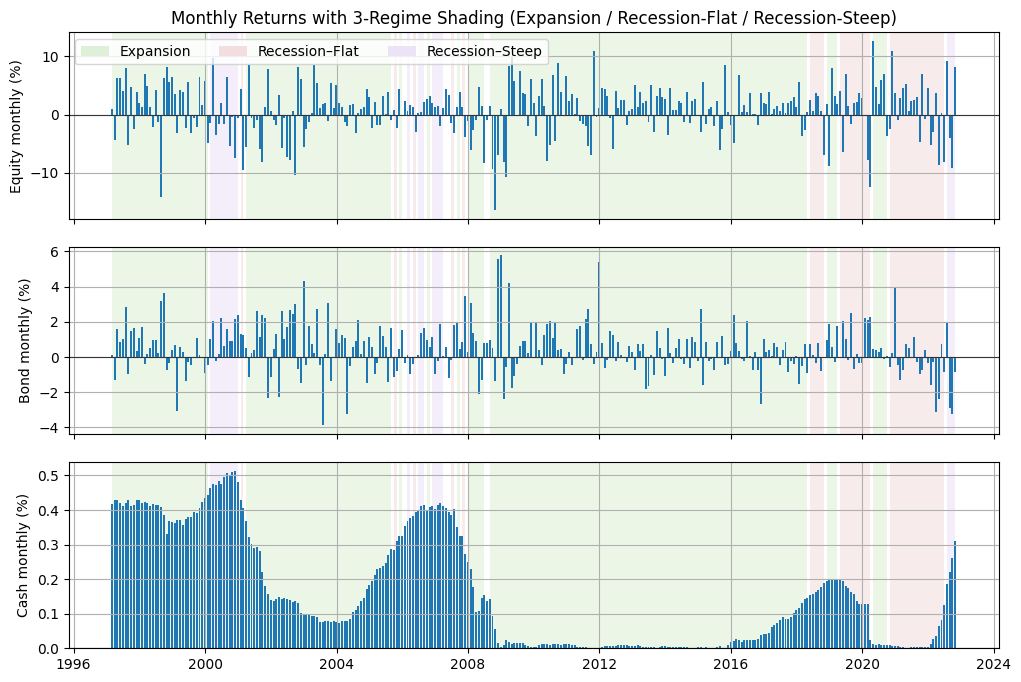

In [49]:
# Colors for 3 regimes
REGIME3_COLORS = {0:"#dff0d8", 1:"#f2dede", 2:"#ede3f7"}  # Expansion, Recession-Flat, Recession-Steep

def contiguous_spans(series: pd.Series):
    s = series.dropna().astype(int).values
    idx = series.dropna().index
    spans=[]; start=0
    for i in range(1,len(s)):
        if s[i]!=s[i-1]:
            spans.append((idx[start], idx[i-1], int(s[i-1])))
            start=i
    spans.append((idx[start], idx[len(s)-1], int(s[len(s)-1])))
    return spans

spans3 = contiguous_spans(df09["regime3"])

fig, axes = plt.subplots(3,1, figsize=(12,8), sharex=True, gridspec_kw={"hspace":0.15})
series_list = [("Equity", df09["ret_eq"]), ("Bond", df09["ret_bond"]), ("Cash", df09["ret_cash"])]

for ax, (lbl, ser) in zip(axes, series_list):
    for s0, s1, rg in spans3:
        ax.axvspan(s0, s1, color=REGIME3_COLORS[rg], alpha=0.6, lw=0)
    ax.bar(ser.index, ser*100, width=22, edgecolor="none")
    ax.axhline(0, color="k", lw=0.8, alpha=0.7)
    ax.set_ylabel(f"{lbl} monthly (%)")

from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=REGIME3_COLORS[k], edgecolor="none", label=REGIME3_NAMES[k]) for k in [0,1,2]]
axes[0].legend(handles=legend_patches, ncol=3, loc="upper left")
axes[0].set_title("Monthly Returns with 3-Regime Shading (Expansion / Recession-Flat / Recession-Steep)")
plt.tight_layout(); plt.show()


In [50]:
from research.interest_rates.scripts.backtesting import RegimeConfig3, evaluate, build_portfolio_returns_3reg

cfg3 = RegimeConfig3(
    lambda_prob=0.7,           # 70% continuous prob sizing + 30% regime policy
    p_ewma_halflife=3,
    up=0.70, down=0.40,        # wider band than before to reduce flips
    confirm=2,
    slope_col="spread_10y_2y",
    slope_ewma_halflife=3,
    min_duration_m=2,          # keep regimes at least 2 months
    w_expansion=(0.80,0.20,0.00),
    w_rec_flat=(0.20,0.60,0.20),
    w_rec_steep=(0.50,0.40,0.10),
    beta_bond=0.7,
    mom_lookback_m=6,
    use_cash_filter=True,
    vol_target_ann=None,       # set 0.10 to enable targeting
    vol_lb_m=36,
    max_leverage=2.0,
)

res3 = build_portfolio_returns_3reg(df, cfg3)
metrics3 = evaluate(res3["r_port"], res3["w_bond"])
print(metrics3)


{'annual_return': np.float64(0.08922991162679783), 'annual_vol': np.float64(0.11023195473639312), 'sharpe': np.float64(0.8331699243670627), 'sortino': np.float64(1.4493165287915457), 'max_drawdown': -0.3270352314901933, 'max_dd_years': 2.8333333333333335, 'turnover': np.float64(0.010750772253769124)}


In [51]:
def _contiguous_spans(series: pd.Series):
    s = series.dropna().astype(int).values
    idx = series.dropna().index
    if len(s) == 0: return []
    spans=[]; start=0
    for i in range(1, len(s)):
        if s[i] != s[i-1]:
            spans.append((idx[start], idx[i-1], int(s[i-1])))
            start = i
    spans.append((idx[start], idx[len(s)-1], int(s[len(s)-1])))
    return spans

def plot_cumret_with_weights(
    res: dict,
    df: pd.DataFrame,
    title_top="Enhanced Regime Strategy — Cumulative Returns",
    save_path=""
):
    """
    Supports both:
      v1 (2-state): res contains ["r_port","w_bond","w_eq"(optional),"w_cash"(optional),"state"(0/1)]
      v2 (3-regime): res contains ["r_port","w_eq","w_bond","w_cash","regime3"]
    Also expects df to have ["ret_eq","ret_bond"] and optional ["ret_cash","p_recession"].
    """
    # ----- sleeves, portfolio wealth
    ret_eq, ret_bd = df["ret_eq"].fillna(0), df["ret_bond"].fillna(0)
    ret_cash = df.get("ret_cash", pd.Series(0.0, index=df.index)).fillna(0)
    port = (1 + res["r_port"].fillna(0)).cumprod()
    eq   = (1 + ret_eq).cumprod()
    bd   = (1 + ret_bd).cumprod()
    cs   = (1 + ret_cash).cumprod()

    # ----- weights
    # Prefer explicit w_eq/w_bond/w_cash if available; else derive from w_bond
    if {"w_eq","w_bond","w_cash"}.issubset(res.keys()):
        w_eq   = res["w_eq"].clip(0,1)
        w_bond = res["w_bond"].clip(0,1)
        w_cash = res["w_cash"].clip(0,1)
    else:
        w_bond = res["w_bond"].clip(0,1)
        w_eq   = 1.0 - w_bond
        w_cash = pd.Series(0.0, index=w_bond.index)

    p = df.get("p_recession", None)
    state = res.get("state", None)            # 0/1 if present
    regime3 = res.get("regime3", None)        # 0=Expansion,1=Rec-Flat,2=Rec-Steep if present

    # ----- figure
    fig = plt.figure(figsize=(11, 7.5))
    gs = fig.add_gridspec(2, 1, height_ratios=[3.2, 1.5], hspace=0.15)

    # Top: cumulative returns
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(port, label="Regime Portfolio", linewidth=2.0)
    ax1.plot(eq,   label="Equities", alpha=0.85)
    ax1.plot(bd,   label="Bonds",    alpha=0.85)
    ax1.plot(cs,   label="Cash",     alpha=0.85)
    ax1.set_title(title_top)
    ax1.set_ylabel("Cumulative Wealth (×)")
    ax1.grid(alpha=0.3)
    ax1.legend(loc="upper left")

    # Annotate quick stats (uses your evaluate)
    m = evaluate(res["r_port"], res.get("w_bond", w_bond))
    ax1.text(
        0.01, 0.02,
        f"Sharpe={m['sharpe']:.2f}\nMax DD={m['max_drawdown']:.1%}\nTurnover={m['turnover']:.2f}",
        transform=ax1.transAxes, va="bottom", ha="left",
        fontsize=9, bbox=dict(facecolor="white", alpha=0.65, edgecolor="none")
    )

    # Bottom: weights (stacked) + optional overlays
    ax2 = fig.add_subplot(gs[1,0], sharex=ax1)

    # Regime shading if regime3 is available
    if regime3 is not None:
        REGIME3_COLORS = {0:"#dff0d8", 1:"#f2dede", 2:"#ede3f7"}  # Expansion / Rec-Flat / Rec-Steep
        spans = _contiguous_spans(regime3)
        for s0, s1, rg in spans:
            ax2.axvspan(s0, s1, color=REGIME3_COLORS[rg], alpha=0.6, lw=0)

        # legend patches
        patches = [Patch(facecolor=REGIME3_COLORS[i], label=l) for i,l in enumerate(["Expansion","Recession–Flat","Recession–Steep"])]
        ax2.legend(handles=patches, loc="upper left", ncol=3, frameon=True)

    # Stacked area: weights
    W = pd.concat([w_eq.rename("Equity"), w_bond.rename("Bond"), w_cash.rename("Cash")], axis=1).fillna(0)
    ax2.stackplot(W.index, W.T.values, labels=W.columns, alpha=0.9)
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_ylabel("Weights")
    ax2.set_xlabel("Date")
    ax2.grid(alpha=0.3)

    # Optional 2-state overlays
    if p is not None:
        ax2.plot(p.clip(0,1), lw=1.2, alpha=0.8, label="p_recession")
    if state is not None:
        ax2.step(state.index, state.values, where="post", alpha=0.4, label="risk-off state (0/1)")

    # Hide x labels on top axes
    plt.setp(ax1.get_xticklabels(), visible=False)

    # _ensure_dir(save_path)
    if save_path != '':
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

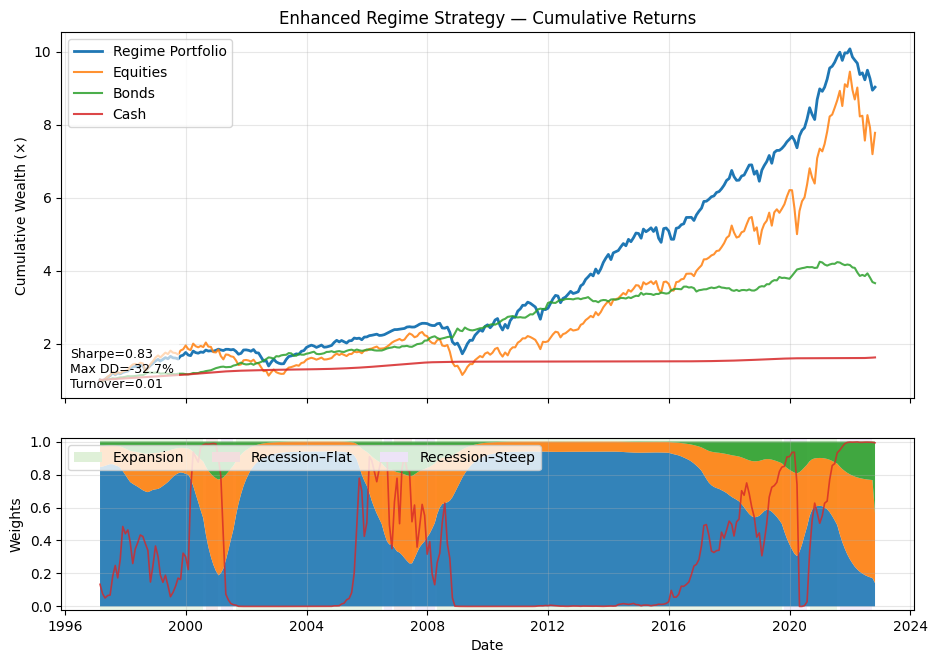

In [55]:
# usage:
res = build_portfolio_returns_3reg(df, cfg3)       # 3-regime engine
plot_cumret_with_weights(res, df)